# How to Build a Product Recommender
> We will build a simple recommender system using co-occurence concept and then save the outputs in an AWS S3 bucket in JSON format.

- toc: true
- badges: false
- comments: true
- categories: [Retail]
- image:

## Introduction

Duration: 5

We will create a simple end-to-end product recommendation system for similar products simply with historical sales data.

### What you'll learn?

1. Build a co-occurence matrix in python
2. Identify similar items with cosine similarity

### Why is this important?

- Simplicity matters! Sometimes simple models beats state of the art AI models in production

### How it will work?

1. Create a sample dataset
2. Build co-occurence matrix
3. Build cosine similarity table
4. Offline model validation
5. Generate JSON of top-k recommendations
6. Store the JSON into S3 bucket

Developers will be able to fetch the JSON into Postgres database. This Postgres database can then be used to serve products on the front end.

### Who is this for?

- People who are looking to build a simple retail recommender system and deploy it on cloud

<!---------------------------->

## Build the dataset

Duration: 5



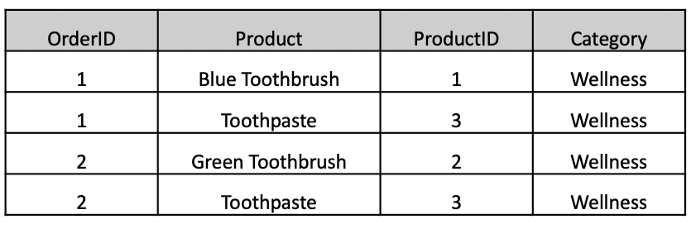

## Build co-occurrence matrix

Duration: 5

```python
import pandas as pd
import numpy as np
import s3fs
import json
from sklearn.metrics.pairwise import cosine_similarity
import datetime

pivot_df = pd.pivot_table(sales_df,index = 'order_id',columns = 'product_id',values = 'category',aggfunc = 'count')
pivot_df.reset_index(inplace=True)
pivot_df = pivot_df.fillna(0)
pivot_df = pivot_df.drop('order_id', axis=1)

co_matrix = pivot_df.T.dot(pivot_df)
np.fill_diagonal(co_matrix.values, 0)
```

<!---------------------------->

## Build cosine similarity table

Duration: 5

```python
cos_score_df = pd.DataFrame(cosine_similarity(co_matrix))
cos_score_df.index = co_matrix.index
cos_score_df.columns = np.array(co_matrix.index)
```



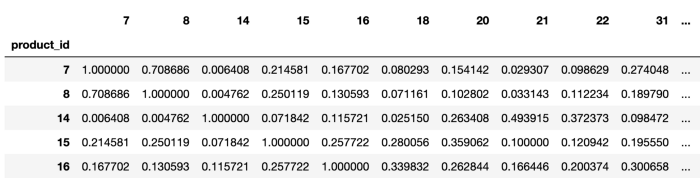

## Offline model validation

Duration: 2

As with most unsupervised learning models, model validation can be tricky. For our dataset we have a diverse set of product categories. Since we are creating a recommender to show similar products we should expect our model to return recommendations that are in the same category as the original base product.

*For Each Product Category: **Count(Best Recommendation for Each Product in Category)/ Count(Products in Category) = % of Recommendations in Same Category***

From here model validation would continue once we promote the first version of our model to production and commence with an AB test. Some parameter tuning considerations as you iterate your model would be having a cosine similarity score threshold or sample size threshold to limit recommendations to ones where we have the highest confidence.

<!---------------------------->

## Generate JSON of top-k recommendations

Duration: 5

```bash
#Take top five scoring recs that aren't the original product
product_recs = []
for i in cos_score_df.index:
    product_recs.append(cos_score_df[cos_score_df.index!=i][i].sort_values(ascending = False)[0:5].index)
    
product_recs_df = pd.DataFrame(product_recs)
product_recs_df['recs_list'] = product_recs_df.values.tolist()
product_recs_df.index = cos_score_df.index
#Semi-colon delimited JSON Output
product_recs_df['json_out'] = product_recs_df['recs_list'].apply(lambda x: [str(element) for element in x])
product_recs_df['json_out'] = product_recs_df['json_out'].apply(lambda x: ";".join(x))
product_recs_dict = product_recs_df.to_dict()
json_out = json.dumps(product_recs_dict['json_out'],indent = 4,ensure_ascii = False).encode('UTF-8')
```

<!---------------------------->

## Store the JSON into an S3 bucket

Duration: 5

```bash
ts = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")
fs = s3fs.S3FileSystem(key=s3_key, secret=s3_value)
with fs.open('s3://yourbucket/key'+ts+'.json', 'wb') as f:
    f.write(bytes(json_out))
```

<!---------------------------->

## Conclusion

Duration: 2

Congratulations!

With all models the quality of your model outputs will be dependent on the quality of your data. Typically the larger sample of orders we have for each product the better; as we would expect to reduce the noise from random product co-occurrences at larger sample sizes. To find the right sample size threshold for your model you can evaluate the model validation metric (% of Recommendations in Same Category) at different sample thresholds to see at which threshold you start seeing a meaningful drop off in the evaluation metric.